In [100]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
from qiskit_aer import AerSimulator
from qiskit.transpiler.passes.synthesis import SolovayKitaev
from qiskit.synthesis import generate_basic_approximations

from qiskit_aer.noise import (NoiseModel, pauli_error)

from qiskit.circuit.library import UnitaryGate

from pyfiles.notebook_config import *

In [92]:
def rot_surf_code(n: int) -> QuantumCircuit:              #1st anc = third last qubit = syndrome/parity measurement qubit, 2nd anc = sec last qubit = magic state for S Gate, 3rd anc = last qubit = magic state for T-Gate
    qr = QuantumRegister(9*n+2, "q")
    cbit = ClassicalRegister(1,"c")
    qc = QuantumCircuit(qr,cbit)
    for i in range(9*n):
        qc.id(i)
    for i in range(n):
        qc.h(9*i+1)
        qc.h(9*i+3)
        qc.h(9*i+5)
        qc.h(9*i+7)

        qc.cx(9*i+1,9*i)
        qc.cx(9*i+5,9*i+4)
        qc.cx(9*i+7,9*i+8)

        qc.cx(9*i+5,9*i+2)

        qc.cx(9*i+3,9*i+4)
        qc.cx(9*i+2,9*i+1)

        qc.cx(9*i+3,9*i+6)

        qc.cx(9*i+6,9*i+7)
    return qc

def X_L(qc: QuantumCircuit, pos=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    global hads
    
    if hads[pos]%2 == 1:
        qc.x(9*pos+3)
        qc.x(9*pos+4)
        qc.x(9*pos+5)
    else:
        qc.x(9*pos+1)
        qc.x(9*pos+4)
        qc.x(9*pos+7)

def Z_L(qc: QuantumCircuit, pos=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    global hads
    
    if hads[pos]%2 == 1:
        qc.z(9*pos+1)
        qc.z(9*pos+4)
        qc.z(9*pos+7)
    else:
        qc.z(9*pos+3)
        qc.z(9*pos+4)
        qc.z(9*pos+5)

def H_L(qc: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        qc.h(9*pos+i)
    global hads
    if pos == 0:
        hads[0] += 1
    else:
        hads[1] += 1

def CNOT(qc:QuantumCircuit, control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    global hads
    if control == 0:
        if [i%2 for i in hads] == [1,0]:
            qc.cx(0,9+6)
            qc.cx(1,9+3)
            qc.cx(2,9+0)
            qc.cx(3,9+7)
            qc.cx(4,9+4)
            qc.cx(5,9+1)
            qc.cx(6,9+8)
            qc.cx(7,9+5)
            qc.cx(8,9+2)
        elif [i%2 for i in hads] == [0,1]:
            qc.cx(0,9+2)
            qc.cx(1,9+5)
            qc.cx(2,9+8)
            qc.cx(3,9+1)
            qc.cx(4,9+4)
            qc.cx(5,9+7)
            qc.cx(6,9+0)
            qc.cx(7,9+3)
            qc.cx(8,9+6)
        else:
            for i in range(9):
                qc.cx(i,9+i)
    elif control == 1:
        if [i%2 for i in hads] == [0,1]:
            qc.cx(9+0,6)
            qc.cx(9+1,3)
            qc.cx(9+2,0)
            qc.cx(9+3,7)
            qc.cx(9+4,4)
            qc.cx(9+5,1)
            qc.cx(9+6,8)
            qc.cx(9+7,5)
            qc.cx(9+8,2)
        elif [i%2 for i in hads] == [1,0]:
            qc.cx(9+0,2)
            qc.cx(9+1,5)
            qc.cx(9+2,8)
            qc.cx(9+3,1)
            qc.cx(9+4,4)
            qc.cx(9+5,7)
            qc.cx(9+6,0)
            qc.cx(9+7,3)
            qc.cx(9+8,6)
        else: 
            for i in range(9):
                qc.cx(9+i,i)

def S_L(qc: QuantumCircuit, pos=0):    
    anc = qc.num_qubits - 1
    qc.reset(anc)

    global hads

    #qc.h(magic_S)
    qc.h(anc)
    qc.s(anc)

    if hads[pos]%2 == 0:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)   

    qc.measure(anc, 0)

    if hads[pos]%2 == 0:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)

def adj_S_L(qc: QuantumCircuit, pos=0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.h(anc)
    qc.sdg(anc)

    global hads

    if hads[pos]%2 == 0:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)       
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if hads[pos]%2 == 0:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    
def T_L(qc: QuantumCircuit, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    qc.h(anc)
    qc.t(anc)

    global hads

    if hads[pos]%2 == 0:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)       
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if hads[pos]%2 == 0:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.s(anc)
            qc.cx(3+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(5+9*pos, anc)
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.s(anc)
            qc.cx(1+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(7+9*pos, anc)    
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

def adj_T_L(qc: QuantumCircuit, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.h(anc)
    qc.tdg(anc)

    global hads

    if hads[pos]%2 == 0:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  
    qc.measure(anc, 0)

    if hads[pos]%2 == 0:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.sdg(anc)
            qc.cx(3+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(5+9*pos, anc) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.h(anc)
            qc.sdg(anc)
            qc.cx(1+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(7+9*pos, anc)   
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

circ = QuantumCircuit(1)
circ.rz(np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
rootT = skd(circ)

def root_T_L(qc: QuantumCircuit, pos = 0):
    # instruction = rootT.data
    # for i in instruction:
    #     if i.name == "t":
    #         T_L(qc, pos=pos)
    #     if i.name == "tdg":
    #         adj_T_L(qc, pos=pos)
    #     if i.name == "h":
    #         H_L(qc, pos=pos)
    #     if i.name == "s":
    #         S_L(qc, pos=pos)
    #     if i.name == "sdg":
    #         adj_S_L(qc, pos=pos)
    #     if i.name == "z":
    #         Z_L(qc, pos=pos)
    instruction = np.array(['t', 'h', 'tdg', 'h', 'tdg', 'h', 't', 'h', 't', 'h', 't', 'h', 'tdg', 'h', 'tdg', 'h'])
    for i in instruction:
        if i == "t":
            T_L(qc, pos=pos)
        if i == "tdg":
            adj_T_L(qc, pos=pos)
        if i == "h":
            H_L(qc, pos=pos)

circ = QuantumCircuit(1)
circ.rz(-np.pi/8, 0)
basis = ["t", "tdg", "z", "h"]
approx = generate_basic_approximations(basis, depth=3)
skd = SolovayKitaev(recursion_degree=2, basic_approximations=approx)
adj_rootT = skd(circ)

def adj_root_T_L(qc: QuantumCircuit, pos = 0):
    instruction = adj_rootT.data
    for i in instruction:
        if i.name == "t":
            T_L(qc, pos=pos)
        if i.name == "tdg":
            adj_T_L(qc, pos=pos)
        if i.name == "h":
            H_L(qc, pos=pos)
        if i.name == "s":
            S_L(qc, pos=pos)
        if i.name == "sdg":
            adj_S_L(qc, pos=pos)
        if i.name == "z":
            Z_L(qc, pos=pos)

def CT_L(qc: QuantumCircuit, qecc = False):
    # if qecc:
    #     qec(qc, pos = 0)
    #     qec(qc, pos = 1)
    root_T_L(qc, pos=0)
    root_T_L(qc, pos=1)
    if qecc:
        qec(qc, pos = 0)
    CNOT(qc, control=0)
    # if qecc:
    #     qec(qc, pos = 0)
    adj_root_T_L(qc, pos=1)
    CNOT(qc, control=0)

def convert(bin: str):                  #konvertiert den bitstring in decimal, e.g. 0110 = 0.375
    k = list(bin)
    a = [int(i) for i in k]
    n = 0
    for i in range(len(a)):
        if a[i] == 1:
            n += 1/2**(i+1)
    return n

def U2(qc: QuantumCircuit, pos: int, gate: list):
    for i in gate:
        if i == "s":
            S_L(qc, pos=pos)
        if i == "sdg":
            adj_S_L(qc, pos=pos)
        if i == "t":
            T_L(qc, pos=pos)
        if i == "tdg":
            adj_T_L(qc, pos=pos)
        if i == "h":
            H_L(qc, pos=pos)
        if i == "z":
            Z_L(qc, pos=pos)

def CU_L(qc: QuantumCircuit, Ugates: list, adjUgates: list, err = False):
    U2(qc, 0, Ugates)
    if err:
        qec(qc, pos=0)
    U2(qc, 1, Ugates)
    if err:
        qec(qc, pos=1)
    CNOT(qc, control=0)
    U2(qc, 1, adjUgates)
    if err:
        qec(qc, pos=1)
    CNOT(qc, control=0)

def Leon(iter: int, n:int, argh: float, err = False, k = 1):       #each iteration own circuit
    angle = np.linspace(0,1,n+2)
    angle = np.delete(angle, [n+1])
    angle = np.delete(angle, [0])

    a, b = [], []
    with open("Unitary/unitary{}.txt".format(n), "r") as file:
        for line in file:
            a.append(list(map(str, line.strip().split(","))))
    with open("Unitary/adjunitary{}.txt".format(n), "r") as file:
        for line in file:
            b.append(list(map(str, line.strip().split(","))))
    
    y = 0
    bruh1 = []
    global hads
    for m in range(k):
        for o in range(n):
            bitstring = ""
            rots = []
            for t in range(iter):
                rots = [k*0.5 for k in rots]
                while True:
                    hads = [0,0]
                    qc = rot_surf_code(2)

                    X_L(qc, 1)
                    H_L(qc, pos=0)
                    #############################
                    for j in range(2**(iter-t-1)):
                        CU_L(qc, a[o], b[o], err=err)
                    ###############################
                    for l in rots:
                        if l == 0.25:
                            adj_S_L(qc, pos=0)
                        if l == 0.125:
                            adj_T_L(qc, pos=0)
                    H_L(qc, pos=0)
                    if err:
                        qec(qc, pos = 0)
                    zeros, ones, err = readout(qc, pos=0, shots=1, noise=argh)
            
                    if zeros == 1:
                        bitstring += "0"
                        break
                    if ones == 1:
                        bitstring += "1"
                        rots.append(0.5)
                        break
            bitstring = bitstring[::-1]
            hmm = convert(bitstring)
            diff = np.abs(hmm-angle[o])
            y += diff
            bruh1.append(diff)
    y = y/(n*k)
    arg = 0
    for i in range(len(bruh1)):
        arg += (y-bruh1[i])**2
    sigma = ((1/(k*n))*arg)**0.5
    sigma = sigma/((k*n)**0.5)

    return y, sigma

def control_S_L(qc: QuantumCircuit):
    T_L(qc, pos=0)
    T_L(qc, pos=1)
    CNOT(qc, control=0)
    adj_T_L(qc, pos=1)
    CNOT(qc, control=0)

def control_Z_L(qc: QuantumCircuit):
    H_L(qc, pos = 1)
    CNOT(qc, control = 0)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    H_L(qc, pos = 1)

def readout(qc: QuantumCircuit, pos: int, shots: int, noise = 0):
    code0 = ['000110101', '110110110', '110110101', '110000000', '000110110', '101101101', '011101101', '011011000', '011011011', '110000011', '000000000', '011101110', '101011011', '101101110', '000000011', '101011000']
    code1 = ['010100111', '010010001', '111111111', '001001010', '111001010', '001111111', '100010010', '111111100', '100100100', '100010001', '001001001', '010010010', '100100111', '111001001', '001111100', '010100100']#
    read = ClassicalRegister(9)
    qc.add_register(read)

    global hads

    for i in range(9):
        qc.id(i+9*pos)
    if hads[pos]%2 == 0:
        for i in range(9):
            qc.measure(i+9*pos, read[8-i])
    elif hads[pos]%2 == 1:
        qc.measure(0+9*pos, read[8-6])
        qc.measure(1+9*pos, read[8-3])
        qc.measure(2+9*pos, read[8-0])
        qc.measure(3+9*pos, read[8-7])
        qc.measure(4+9*pos, read[8-4])
        qc.measure(5+9*pos, read[8-1])
        qc.measure(6+9*pos, read[8-8])
        qc.measure(7+9*pos, read[8-5])
        qc.measure(8+9*pos, read[8-2])

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XI",p/4],["IX",p/4],["II",1-p],["ZI",p/4],["IZ",p/4]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h', "id", "s", "t"])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bitstring = list(counts.keys())
    hmm = list(counts.values())

    bitstring = [i.replace(" ","") for i in bitstring]

    allcbits = len(bitstring[0])
    bits = [i[:9] for i in bitstring]

    flags = [i[9:allcbits-2] for i in bitstring]

    for i in range(len(bits)):
        for j in code0:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in code1:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            bits[i] = 2
    
    for i in range(len(flags)):
        if flags[i].count("1") != 0:
            bits[i] = 2

    ones = 0
    zeros = 0
    err = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            zeros += hmm[i]
        if bits[i] == 1:
            ones += hmm[i]
        if bits[i] == 2:
            err += hmm[i]
    
    ones = (ones/shots)
    zeros = (zeros/shots)
    err = (err/shots)

    return zeros, ones, err

def qec(qc: QuantumCircuit, pos = 0):           #68 gates
    flags = ClassicalRegister(8)
    qc.add_register(flags)
    anc = qc.num_qubits - 1
    ancc = anc - 1
    if hads[pos]%2==1:
        #X3 X6 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.h(anc)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, 6+9*pos)
        qc.h(anc)
        qc.id(anc)
        qc.measure(anc,0)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc)
        qc.cx(anc, ancc)
        qc.cx(anc, 0+9*pos)
        qc.cx(anc, 1+9*pos)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, ancc)
        qc.cx(anc, 4+9*pos)
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,1), qc.measure(ancc, flags[1])

        #X4 X5 X7 X8 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc)
        qc.cx(anc, ancc)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, 5+9*pos)
        qc.cx(anc, 7+9*pos)
        qc.cx(anc, ancc)
        qc.cx(anc, 8+9*pos)
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,2), qc.measure(ancc, flags[2])

        #X2 X5 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.h(anc)
        qc.cx(anc, 2+9*pos)
        qc.cx(anc, 5+9*pos)
        qc.h(anc)
        qc.id(anc)
        qc.measure(anc,3)

        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.z(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.z(3+9*pos)

        with qc.if_test((3,1)):             #2
            with qc.if_test((2,0)):
                qc.z(2+9*pos)
        
        with qc.if_test((3,1)):             #5
            with qc.if_test((2,1)):
                qc.z(5+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.z(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(7+9*pos)

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.cx(0+9*pos, anc)
        qc.cx(1+9*pos, anc)
        qc.id(anc)
        qc.measure(anc,0)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc)
        qc.cx(ancc, anc)
        qc.cx(1+9*pos, anc)
        qc.cx(2+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(ancc, anc)
        qc.cx(5+9*pos, anc)
        qc.h(ancc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,1), qc.measure(ancc, flags[5])
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc)
        qc.cx(ancc, anc)
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(6+9*pos, anc)
        qc.cx(ancc, anc)
        qc.cx(7+9*pos, anc)
        qc.h(ancc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,2), qc.measure(ancc, flags[6])

        #Z7 Z8 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.cx(7+9*pos, anc)
        qc.cx(8+9*pos, anc)
        qc.id(anc)
        qc.measure(anc,3)
        
        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):
                qc.x(0+9*pos)

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.x(1+9*pos)
        
        with qc.if_test((3,1)):             #8
            with qc.if_test((2,0)):
                qc.x(8+9*pos)
        
        with qc.if_test((3,1)):             #7
            with qc.if_test((2,1)):
                qc.x(7+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(2+9*pos)
        
        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(3+9*pos)

    else:
        #X0 X1 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.h(anc)
        qc.cx(anc, 0+9*pos)
        qc.cx(anc, 1+9*pos)
        qc.h(anc)
        qc.id(anc)
        qc.measure(anc,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc)
        qc.cx(anc, ancc)
        qc.cx(anc, 1+9*pos)
        qc.cx(anc, 2+9*pos)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, ancc)
        qc.cx(anc, 5+9*pos)
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,1), qc.measure(ancc, flags[1])

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(anc)
        qc.cx(anc, ancc)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, 6+9*pos)
        qc.cx(anc, ancc)
        qc.cx(anc, 7+9*pos)
        qc.h(anc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,2), qc.measure(ancc, flags[2])

        #X7 X8 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.h(anc)
        qc.cx(anc, 7+9*pos)
        qc.cx(anc, 8+9*pos)
        qc.h(anc)
        qc.id(anc)
        qc.measure(anc,3)

        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):    
                qc.z(0+9*pos)

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.z(1+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((2,1)):             #7
            with qc.if_test((3,1)):
                qc.z(7+9*pos)

        with qc.if_test((2,0)):             #8
            with qc.if_test((3,1)):
                qc.z(8+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):        
                with qc.if_test((2,0)):    
                    qc.z(2+9*pos)

        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(3+9*pos)

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.cx(3+9*pos, anc)
        qc.cx(6+9*pos, anc)
        qc.id(anc)
        qc.measure(anc,0)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc)
        qc.cx(ancc, anc)
        qc.cx(0+9*pos, anc)
        qc.cx(1+9*pos, anc)
        qc.cx(3+9*pos, anc)
        qc.cx(ancc, anc)
        qc.cx(4+9*pos, anc)
        qc.h(ancc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,1), qc.measure(ancc, flags[5])
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(anc), qc.reset(ancc)
        qc.id(anc), qc.id(ancc)
        qc.h(ancc)
        qc.cx(ancc, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)
        qc.cx(7+9*pos, anc)
        qc.cx(ancc, anc)
        qc.cx(8+9*pos, anc)
        qc.h(ancc)
        qc.id(anc), qc.id(ancc)
        qc.measure(anc,2), qc.measure(ancc, flags[6])

        #Z2 Z5 Stabilizer:
        qc.reset(anc)
        qc.id(anc)
        qc.cx(2+9*pos, anc)
        qc.cx(5+9*pos, anc)
        qc.id(anc)
        qc.measure(anc,3)
        
        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.x(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.x(3+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((2,0)):             #2
            with qc.if_test((3,1)):
                qc.x(2+9*pos)

        with qc.if_test((2,1)):             #5
            with qc.if_test((3,1)):
                qc.x(5+9*pos)
        
        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(7+9*pos)

def gates(qc:QuantumCircuit):
    hmm = dict(qc.count_ops())
    hmm["reset"] = 0
    hmm["measure"] = 0
    hmm["if_else"] = 0
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

In [9]:
n = 15

angle = np.linspace(0,1,n+2)
angle = np.delete(angle, [n+1])
angle = np.delete(angle, [0])

a, b = [], []
with open("text/unitary{}.txt".format(n), "r") as file:
    for line in file:
        a.append(list(map(str, line.strip().split(","))))
with open("text/adjunitary{}.txt".format(n), "r") as file:
    for line in file:
        b.append(list(map(str, line.strip().split(","))))

In [32]:
hads = [0,0]
qc = rot_surf_code(2)

counter = 0

X_L(qc, 1)
H_L(qc, pos=0)
#############################
for j in range(1):
    CT_L(qc, qecc=False)
###############################
H_L(qc, pos=0)

qec(qc, 0)

gates(qc)

hmm = dict(qc.count_ops())
hmm["reset"] = 0
hmm["measure"] = 0
hmm["if_else"] = 0
counter += sum(hmm.values())

Amount of gates in this circuit:  485


In [ ]:
shots = 50

noise = np.linspace(0,0.01,4)

success = []

for i in noise:
    hads = [0,0]
    qc = rot_surf_code(2)

    X_L(qc, 1)
    H_L(qc, pos=0)
    #############################
    root_T_L(qc, 0), root_T_L(qc, 1)
    CNOT(qc, 0)
    #qec(qc, 0)
    adj_root_T_L(qc, 1)
    CNOT(qc, 0)
    ###############################
    adj_T_L(qc, 0)
    H_L(qc, pos=0)

    zeros, ones, err = readout(qc, 0, shots=shots, noise=i)
    success.append(zeros/(zeros+ones))

# print("Zeros: ", zeros)
# print("Ones: ", ones)
# print("Err: ", err)

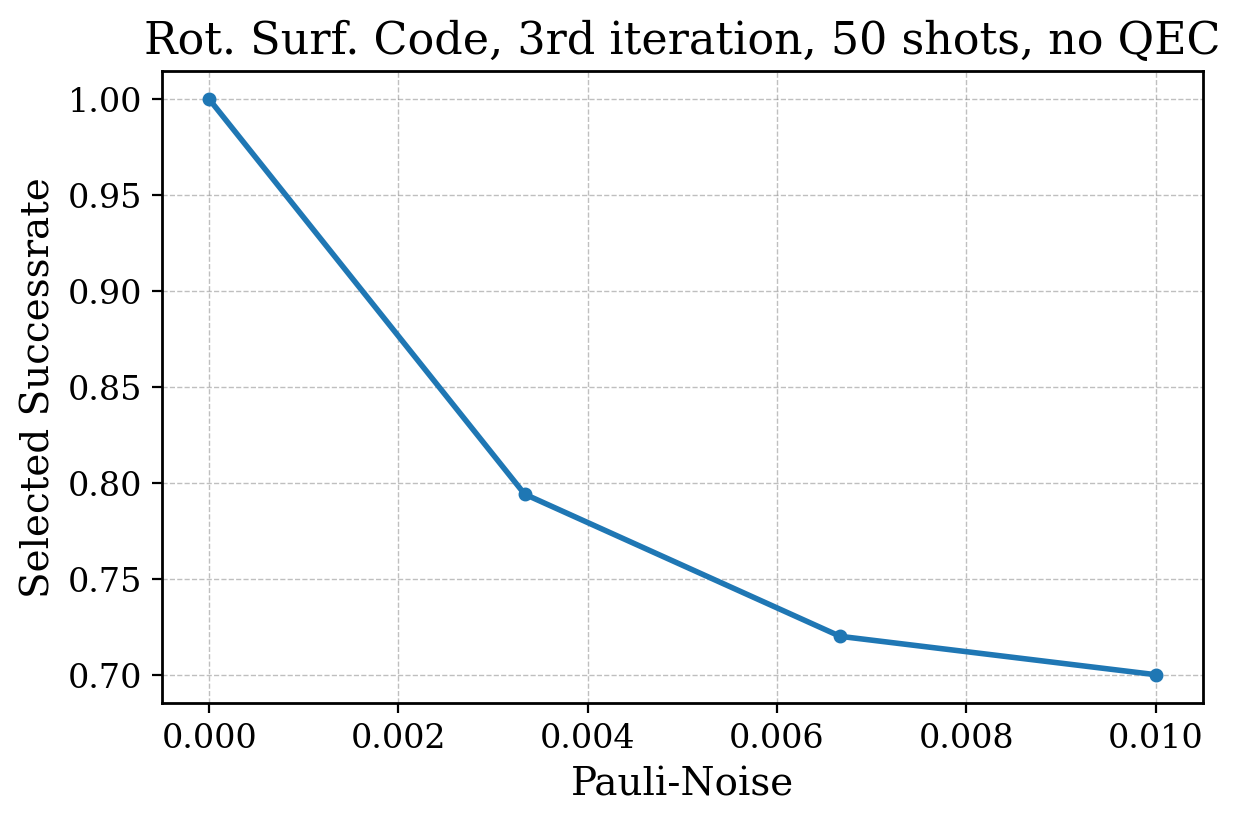

In [109]:
plt.xlabel("Pauli-Noise")
plt.title("Rot. Surf. Code, 3rd iteration, {} shots, no QEC".format(shots))
plt.ylabel("Selected Successrate")
plt.plot(noise, success, marker=".")